In [60]:
import torch
from torch import nn
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
from collections import OrderedDict

from scipy.interpolate import InterpolatedUnivariateSpline as IUS
%matplotlib inline

Choose parameters for miniminising interpolation error:

k: degree of interpolating piecewise polynommials

m: Order of derivatives in the Hilbert space 0 <= m <= k

p: norm in Sobolev space

Choose k = 1 and m = 0 and p = 2

Error bound is by Ciarlet equal to 

|u - u_k|^2_H^m <= C sum h_j^5 |u|^2_H^2  if u in H^2

For simplicity replace |u| by evaluating u directly at the midpoint of the interval h_j.

The output of the network must be the transformation map xi -> x.

The loss function must be computed passing all the coordinates.

In [62]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [5]:
# activaction function
class softplus_power(torch.nn.Module):
    def __init(self):
        super.__init__()

    def forward(self, x):
        m = nn.Softplus()
        x = m(x)
        return x**1.1

In [6]:
class ResNN(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_layers, n_npl,lb,ub):
        super().__init__()
        self.n_inps = n_inputs
        self.lb = lb
        self.ub = ub
        if n_layers == 0:
            self.layers = nn.ModuleList()
            self.activations = nn.ModuleList()
            self.layers.append(nn.Linear(n_inputs, n_outputs))
        else:
            self.layers = nn.ModuleList()
            self.activations = nn.ModuleList()

            self.layers.append(nn.Linear(n_inputs, n_npl))
            self.activations.append(nn.Tanh())

            for x in range(n_layers-1):
                # add n_inputs as shown in Fig.1 in the paper
                self.layers.append(nn.Linear(n_npl + n_inputs, n_npl))
                self.activations.append(nn.Tanh())
            self.layers.append(nn.Linear(n_npl + n_inputs, n_outputs))

    '''
    Forward pass - Simple fully connected network with given activations
    '''

    def forward(self, x):
        inps = x
        out = x
        for i in range(len(self.layers)-1):
            if i > 0:
                # stack out and inps along dim = 1 as hstack
                # from the second layer the activaction function is activated on n° nodes: inps + out
                out = torch.cat((out, inps), dim=1)
            out = self.layers[i](out)
            out = self.activations[i](out)

        if len(self.layers) != 1:
            out = torch.cat((out, inps), dim=1)

        # out is of shape (ndata,1)
        out = self.layers[-1](out)
        out = rescale(out,self.lb,self.ub)    
        return out
    
    
    def make_convex(self):
        with torch.no_grad():
            for i in range(1, len(self.layers)):
                if i == 0:
                    self.layers[i].weight[:, :][self.layers[i].weight[:, :] < 0] = \
                        torch.abs(self.layers[i].weight[:, :]
                                  [self.layers[i].weight[:, :] < 0])
                self.layers[i].weight[:, :-self.n_inps][self.layers[i].weight[:, :-self.n_inps] < 0] = \
                    torch.abs(self.layers[i].weight[:, :-self.n_inps]
                              [self.layers[i].weight[:, :-self.n_inps] < 0])

    '''
    Sets all negative weights (W^z) to 0
    '''

    def project(self):
        with torch.no_grad():
            for i in range(1, len(self.layers)):
                if i == 0:
                    self.layers[i].weight[:,
                                          :][self.layers[i].weight[:, :] < 0] = 0
                self.layers[i].weight[:, :-
                                      self.n_inps][self.layers[i].weight[:, :-self.n_inps] < 0] = 0

    

In [7]:
# the deep neural network
class DNN(torch.nn.Module):
    
    # layers count the hiddens + the output 
    def __init__(self, layers, lb, ub):
        
        super().__init__()
        
        # parameters
        self.depth = len(layers) - 1
        self.lb = lb
        self.ub = ub
        #self.activation = softplus_power
        #self.activation = nn.Tanh
        
        # set up layer order dict
        self.layers = torch.nn.ModuleList()
        self.activations = torch.nn.ModuleList()
        
        for i in range(self.depth - 1): 
            self.layers.append(torch.nn.Linear(layers[i], layers[i+1]))
            self.activations.append(nn.Tanh())
            
        self.layers.append(nn.Linear(layers[-2], layers[-1]))
    
                                     
    def forward(self, x):
        
        out = x
        for i in range(len(self.layers)-1):
            out = self.layers[i](out)
            out = self.activations[i](out)

        # out is of shape (ndata,1)
        out = self.layers[-1](out)
        out = rescale(out,self.lb,self.ub)    
        return out
    
    
    
    def make_convex(self):
        with torch.no_grad():
            for i in range(1, len(self.layers)):
                if i == 0:
                    self.layers[i].weight[:, :][self.layers[i].weight[:, :] < 0] = \
                        torch.abs(self.layers[i].weight[:, :]
                                  [self.layers[i].weight[:, :] < 0])
                self.layers[i].weight[:, :-self.n_inps][self.layers[i].weight[:, :-self.n_inps] < 0] = \
                    torch.abs(self.layers[i].weight[:, :-self.n_inps]
                              [self.layers[i].weight[:, :-self.n_inps] < 0])

    '''
    Sets all negative weights (W^z) to 0
    '''

    def project(self):
        with torch.no_grad():
            for i in range(1, len(self.layers)):
                if i == 0:
                    self.layers[i].weight[:,
                                          :][self.layers[i].weight[:, :] < 0] = 0
                self.layers[i].weight[:, :-
                                      self.n_inps][self.layers[i].weight[:, :-self.n_inps] < 0] = 0


In [8]:
  def rescale(x,lb,ub):
    """ rescaling function to impose boundary conditions """           
    torch.sort(x)[0]
    y = x - torch.min(x) 
    z = y.squeeze()/(torch.max(y).squeeze())
    z = lb + (ub - lb)*z
    
    return z 

### The Physics-Informed Neural Network

self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(),   # derived from class nn.Module
            lr=0.01,                  # default is 1
            max_iter=1000, 
            max_eval=1000, 
            history_size=50,
            tolerance_grad=1e-10, 
            tolerance_change=1.0 * np.finfo(float).eps,   # Machine limits for floating point types.
            #line_search_fn="strong_wolfe"       # can be "strong_wolfe" worse result
        )

In [9]:
class PhysicsInformedNN():

    def __init__(self, N, xi, u, layers, lb, ub, netRes = True):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.N = N
        self.xi = torch.tensor(xi, requires_grad=True).float().to(device).unsqueeze(-1)
        self.layers = layers
        self.u = u
        self.alpha = 1 
        
        # deep neural networks
        #self.dnn = DNN(self.layers,self.lb,self.ub).to(device)
        
        if netRes:
            self.dnn = ResNN(1,1,5,128,self.lb,self.ub).to(device)
        else:
            self.dnn = DNN(self.layers,self.lb,self.ub).to(device)
        # optimizers: using the same settings
        #self.optimizer = torch.optim.Adam(self.dnn.parameters())
        self.optimizer = torch.optim.Adadelta(self.dnn.parameters(),lr = 0.1)
        

        self.iter = 0
    
    def second_derivative(self,p,res):
        
        """ Compute second derivative given res """
        
        X = p.detach().cpu().numpy()
        Y = res.detach().cpu().numpy()
        # interpolate with scipy and compute second derivative at the required points
        #print(X)
        u = IUS(X,Y)
        u_x = u.derivative()
        u_xx = u_x.derivative()
        
        # evaluate second derivative directly at middle points p
        x = (p[1:] + p[:-1])/2
        x = x.detach().cpu().numpy()
        
        res = u_xx(x) 
        
        return res
        
    def net_grad(self,N,xi,alpha):
        
        """ The pytorch autograd version of calculating residual """
        p = self.dnn(xi)
        h = p.squeeze()
        h = h[1:] - h[:-1]
        
        k = 1
        m = 0
        
        res = self.u(p)
        res = self.second_derivative(p,res)
        res = torch.tensor(res).float().to(device)
        integral = torch.pow(res,2).squeeze()
        
        #print('integral',integral)
        f = h*(alpha*integral)**(1/(1+2*(k-m+1)))
        f = torch.pow(f,1+2*(k-m+1))
        return f,p
    
    def loss_func(self):
        
        self.optimizer.zero_grad()
        
        k = 1
        m = 0
        
        f_pred,p = self.net_grad(self.N,self.xi,self.alpha)
        loss_f = ((self.N-1)**(2*(k-m+1)))*self.alpha*torch.sum(f_pred)
        loss_u = torch.sum(torch.pow(self.u(p[0]),2) + torch.pow(self.u(p[-1]),2))
        loss_xi = torch.sum(torch.pow(self.lb - p[0],2) + torch.pow(self.ub - p[-1],2))
        
        loss = loss_f 
        loss.backward()
        print('Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item()))
        return loss
    
    def train(self):
        self.dnn.train()
        self.iter += 1   
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, Xi):
        
        Xi = torch.tensor(Xi, requires_grad=True).float().unsqueeze(-1).to(device)
        self.dnn.eval()
        p = self.dnn(Xi)
        p = rescale(p,self.lb,self.ub)
        return p

In [21]:
# create uniform mesh with N points
N = 200
a = 0
b = 2*np.pi

u = torch.sin
xi = np.linspace(a,b,N)

layers_DNN = [1, 128, 128, 128, 128,  1]
layers_ResNN = [1, 1, 5, 128]

### Training

In [22]:
# reset model paramters
net = ResNN(*layers_ResNN,a,b)
dic = net.state_dict()
for k in dic:
    dic[k] *= 0
net.load_state_dict(dic)
del(dic)

In [23]:
model = PhysicsInformedNN(N, xi, u, layers_ResNN, a, b,netRes=1)

In [24]:
%%time

net.make_convex()

# define n_epochs and train for that epochs 
nepochs = 5000
for _ in range(nepochs):
    model.train()
    net.project()

Iter 1, Loss: 8.19702e+03, Loss_u: 3.05710e-14, Loss_f: 8.19702e+03
Iter 2, Loss: 5.49072e+03, Loss_u: 3.05710e-14, Loss_f: 5.49072e+03
Iter 3, Loss: 4.98397e+03, Loss_u: 3.05710e-14, Loss_f: 4.98397e+03
Iter 4, Loss: 4.71405e+03, Loss_u: 3.05710e-14, Loss_f: 4.71405e+03
Iter 5, Loss: 4.57764e+03, Loss_u: 3.05710e-14, Loss_f: 4.57764e+03
Iter 6, Loss: 4.53552e+03, Loss_u: 3.05710e-14, Loss_f: 4.53552e+03
Iter 7, Loss: 4.86507e+03, Loss_u: 3.05710e-14, Loss_f: 4.86507e+03
Iter 8, Loss: 5.62310e+03, Loss_u: 3.05710e-14, Loss_f: 5.62310e+03
Iter 9, Loss: 6.24557e+03, Loss_u: 3.05710e-14, Loss_f: 6.24557e+03
Iter 10, Loss: 4.80460e+03, Loss_u: 3.05710e-14, Loss_f: 4.80460e+03
Iter 11, Loss: 4.53143e+03, Loss_u: 3.05710e-14, Loss_f: 4.53143e+03
Iter 12, Loss: 4.44192e+03, Loss_u: 3.05710e-14, Loss_f: 4.44192e+03
Iter 13, Loss: 4.43008e+03, Loss_u: 3.05710e-14, Loss_f: 4.43008e+03
Iter 14, Loss: 4.41956e+03, Loss_u: 3.05710e-14, Loss_f: 4.41956e+03
Iter 15, Loss: 4.43420e+03, Loss_u: 3.05710

Iter 165, Loss: 4.50037e+03, Loss_u: 3.05710e-14, Loss_f: 4.50037e+03
Iter 166, Loss: 4.29925e+03, Loss_u: 3.05710e-14, Loss_f: 4.29925e+03
Iter 167, Loss: 4.35871e+03, Loss_u: 3.05710e-14, Loss_f: 4.35871e+03
Iter 168, Loss: 4.32137e+03, Loss_u: 3.05710e-14, Loss_f: 4.32137e+03
Iter 169, Loss: 4.53706e+03, Loss_u: 3.05710e-14, Loss_f: 4.53706e+03
Iter 170, Loss: 4.59409e+03, Loss_u: 3.05710e-14, Loss_f: 4.59409e+03
Iter 171, Loss: 4.22528e+03, Loss_u: 3.05710e-14, Loss_f: 4.22528e+03
Iter 172, Loss: 4.41671e+03, Loss_u: 3.05710e-14, Loss_f: 4.41671e+03
Iter 173, Loss: 4.26380e+03, Loss_u: 3.05710e-14, Loss_f: 4.26380e+03
Iter 174, Loss: 4.82330e+03, Loss_u: 3.05710e-14, Loss_f: 4.82330e+03
Iter 175, Loss: 4.62574e+03, Loss_u: 3.05710e-14, Loss_f: 4.62574e+03
Iter 176, Loss: 4.29779e+03, Loss_u: 3.05710e-14, Loss_f: 4.29779e+03
Iter 177, Loss: 4.32183e+03, Loss_u: 3.05710e-14, Loss_f: 4.32183e+03
Iter 178, Loss: 4.31893e+03, Loss_u: 3.05710e-14, Loss_f: 4.31893e+03
Iter 179, Loss: 4.38

Iter 330, Loss: 3.92147e+03, Loss_u: 3.05710e-14, Loss_f: 3.92147e+03
Iter 331, Loss: 4.11849e+03, Loss_u: 3.05710e-14, Loss_f: 4.11849e+03
Iter 332, Loss: 4.38948e+03, Loss_u: 3.05710e-14, Loss_f: 4.38948e+03
Iter 333, Loss: 4.02835e+03, Loss_u: 3.05710e-14, Loss_f: 4.02835e+03
Iter 334, Loss: 4.10744e+03, Loss_u: 3.05710e-14, Loss_f: 4.10744e+03
Iter 335, Loss: 4.17005e+03, Loss_u: 3.05710e-14, Loss_f: 4.17005e+03
Iter 336, Loss: 4.27285e+03, Loss_u: 3.05710e-14, Loss_f: 4.27285e+03
Iter 337, Loss: 3.94243e+03, Loss_u: 3.05710e-14, Loss_f: 3.94243e+03
Iter 338, Loss: 3.93011e+03, Loss_u: 3.05710e-14, Loss_f: 3.93011e+03
Iter 339, Loss: 4.15750e+03, Loss_u: 3.05710e-14, Loss_f: 4.15750e+03
Iter 340, Loss: 4.24808e+03, Loss_u: 3.05710e-14, Loss_f: 4.24808e+03
Iter 341, Loss: 4.00614e+03, Loss_u: 3.05710e-14, Loss_f: 4.00614e+03
Iter 342, Loss: 4.01763e+03, Loss_u: 3.05710e-14, Loss_f: 4.01763e+03
Iter 343, Loss: 4.16821e+03, Loss_u: 3.05710e-14, Loss_f: 4.16821e+03
Iter 344, Loss: 4.20

Iter 496, Loss: 3.88226e+03, Loss_u: 3.05710e-14, Loss_f: 3.88226e+03
Iter 497, Loss: 3.98322e+03, Loss_u: 3.05710e-14, Loss_f: 3.98322e+03
Iter 498, Loss: 4.12274e+03, Loss_u: 3.05710e-14, Loss_f: 4.12274e+03
Iter 499, Loss: 3.76806e+03, Loss_u: 3.05710e-14, Loss_f: 3.76806e+03
Iter 500, Loss: 3.82552e+03, Loss_u: 3.05710e-14, Loss_f: 3.82552e+03
Iter 501, Loss: 3.81129e+03, Loss_u: 3.05710e-14, Loss_f: 3.81129e+03
Iter 502, Loss: 4.08757e+03, Loss_u: 3.05710e-14, Loss_f: 4.08757e+03
Iter 503, Loss: 4.00287e+03, Loss_u: 3.05710e-14, Loss_f: 4.00287e+03
Iter 504, Loss: 3.74824e+03, Loss_u: 3.05710e-14, Loss_f: 3.74824e+03
Iter 505, Loss: 3.78716e+03, Loss_u: 3.05710e-14, Loss_f: 3.78716e+03
Iter 506, Loss: 3.77689e+03, Loss_u: 3.05710e-14, Loss_f: 3.77689e+03
Iter 507, Loss: 4.01598e+03, Loss_u: 3.05710e-14, Loss_f: 4.01598e+03
Iter 508, Loss: 4.00217e+03, Loss_u: 3.05710e-14, Loss_f: 4.00217e+03
Iter 509, Loss: 3.77238e+03, Loss_u: 3.05710e-14, Loss_f: 3.77238e+03
Iter 510, Loss: 3.77

Iter 653, Loss: 3.73036e+03, Loss_u: 3.05710e-14, Loss_f: 3.73036e+03
Iter 654, Loss: 3.57538e+03, Loss_u: 3.05710e-14, Loss_f: 3.57538e+03
Iter 655, Loss: 3.77906e+03, Loss_u: 3.05710e-14, Loss_f: 3.77906e+03
Iter 656, Loss: 3.50578e+03, Loss_u: 3.05710e-14, Loss_f: 3.50578e+03
Iter 657, Loss: 3.75627e+03, Loss_u: 3.05710e-14, Loss_f: 3.75627e+03
Iter 658, Loss: 3.47315e+03, Loss_u: 3.05710e-14, Loss_f: 3.47315e+03
Iter 659, Loss: 3.85238e+03, Loss_u: 3.05710e-14, Loss_f: 3.85238e+03
Iter 660, Loss: 3.51126e+03, Loss_u: 3.05710e-14, Loss_f: 3.51126e+03
Iter 661, Loss: 3.82506e+03, Loss_u: 3.05710e-14, Loss_f: 3.82506e+03
Iter 662, Loss: 3.65519e+03, Loss_u: 3.05710e-14, Loss_f: 3.65519e+03
Iter 663, Loss: 4.07505e+03, Loss_u: 3.05710e-14, Loss_f: 4.07505e+03
Iter 664, Loss: 3.98744e+03, Loss_u: 3.05710e-14, Loss_f: 3.98744e+03
Iter 665, Loss: 3.61435e+03, Loss_u: 3.05710e-14, Loss_f: 3.61435e+03
Iter 666, Loss: 3.76129e+03, Loss_u: 3.05710e-14, Loss_f: 3.76129e+03
Iter 667, Loss: 3.53

Iter 811, Loss: 3.56369e+03, Loss_u: 3.05710e-14, Loss_f: 3.56369e+03
Iter 812, Loss: 3.66919e+03, Loss_u: 3.05710e-14, Loss_f: 3.66919e+03
Iter 813, Loss: 3.61079e+03, Loss_u: 3.05710e-14, Loss_f: 3.61079e+03
Iter 814, Loss: 3.64701e+03, Loss_u: 3.05710e-14, Loss_f: 3.64701e+03
Iter 815, Loss: 3.46967e+03, Loss_u: 3.05710e-14, Loss_f: 3.46967e+03
Iter 816, Loss: 3.78338e+03, Loss_u: 3.05710e-14, Loss_f: 3.78338e+03
Iter 817, Loss: 3.48822e+03, Loss_u: 3.05710e-14, Loss_f: 3.48822e+03
Iter 818, Loss: 3.79322e+03, Loss_u: 3.05710e-14, Loss_f: 3.79322e+03
Iter 819, Loss: 3.73737e+03, Loss_u: 3.05710e-14, Loss_f: 3.73737e+03
Iter 820, Loss: 3.58030e+03, Loss_u: 3.05710e-14, Loss_f: 3.58030e+03
Iter 821, Loss: 3.75060e+03, Loss_u: 3.05710e-14, Loss_f: 3.75060e+03
Iter 822, Loss: 3.68272e+03, Loss_u: 3.05710e-14, Loss_f: 3.68272e+03
Iter 823, Loss: 3.56919e+03, Loss_u: 3.05710e-14, Loss_f: 3.56919e+03
Iter 824, Loss: 3.50244e+03, Loss_u: 3.05710e-14, Loss_f: 3.50244e+03
Iter 825, Loss: 3.78

Iter 974, Loss: 3.71795e+03, Loss_u: 3.05710e-14, Loss_f: 3.71795e+03
Iter 975, Loss: 3.77235e+03, Loss_u: 3.05710e-14, Loss_f: 3.77235e+03
Iter 976, Loss: 3.63220e+03, Loss_u: 3.05710e-14, Loss_f: 3.63220e+03
Iter 977, Loss: 3.66180e+03, Loss_u: 3.05710e-14, Loss_f: 3.66180e+03
Iter 978, Loss: 4.11276e+03, Loss_u: 3.05710e-14, Loss_f: 4.11276e+03
Iter 979, Loss: 3.71821e+03, Loss_u: 3.05710e-14, Loss_f: 3.71821e+03
Iter 980, Loss: 3.42006e+03, Loss_u: 3.05710e-14, Loss_f: 3.42006e+03
Iter 981, Loss: 3.64235e+03, Loss_u: 3.05710e-14, Loss_f: 3.64235e+03
Iter 982, Loss: 3.41971e+03, Loss_u: 3.05710e-14, Loss_f: 3.41971e+03
Iter 983, Loss: 3.82275e+03, Loss_u: 3.05710e-14, Loss_f: 3.82275e+03
Iter 984, Loss: 3.59069e+03, Loss_u: 3.05710e-14, Loss_f: 3.59069e+03
Iter 985, Loss: 3.61608e+03, Loss_u: 3.05710e-14, Loss_f: 3.61608e+03
Iter 986, Loss: 3.57918e+03, Loss_u: 3.05710e-14, Loss_f: 3.57918e+03
Iter 987, Loss: 3.56797e+03, Loss_u: 3.05710e-14, Loss_f: 3.56797e+03
Iter 988, Loss: 3.57

Iter 1135, Loss: 3.70540e+03, Loss_u: 3.05710e-14, Loss_f: 3.70540e+03
Iter 1136, Loss: 3.53191e+03, Loss_u: 3.05710e-14, Loss_f: 3.53191e+03
Iter 1137, Loss: 3.59890e+03, Loss_u: 3.05710e-14, Loss_f: 3.59890e+03
Iter 1138, Loss: 3.49041e+03, Loss_u: 3.05710e-14, Loss_f: 3.49041e+03
Iter 1139, Loss: 3.58412e+03, Loss_u: 3.05710e-14, Loss_f: 3.58412e+03
Iter 1140, Loss: 3.58156e+03, Loss_u: 3.05710e-14, Loss_f: 3.58156e+03
Iter 1141, Loss: 3.60538e+03, Loss_u: 3.05710e-14, Loss_f: 3.60538e+03
Iter 1142, Loss: 3.50106e+03, Loss_u: 3.05710e-14, Loss_f: 3.50106e+03
Iter 1143, Loss: 3.83589e+03, Loss_u: 3.05710e-14, Loss_f: 3.83589e+03
Iter 1144, Loss: 3.67627e+03, Loss_u: 3.05710e-14, Loss_f: 3.67627e+03
Iter 1145, Loss: 3.48262e+03, Loss_u: 3.05710e-14, Loss_f: 3.48262e+03
Iter 1146, Loss: 3.55319e+03, Loss_u: 3.05710e-14, Loss_f: 3.55319e+03
Iter 1147, Loss: 3.41203e+03, Loss_u: 3.05710e-14, Loss_f: 3.41203e+03
Iter 1148, Loss: 3.74488e+03, Loss_u: 3.05710e-14, Loss_f: 3.74488e+03
Iter 1

Iter 1303, Loss: 3.69658e+03, Loss_u: 3.05710e-14, Loss_f: 3.69658e+03
Iter 1304, Loss: 3.50738e+03, Loss_u: 3.05710e-14, Loss_f: 3.50738e+03
Iter 1305, Loss: 3.64460e+03, Loss_u: 3.05710e-14, Loss_f: 3.64460e+03
Iter 1306, Loss: 3.91814e+03, Loss_u: 3.05710e-14, Loss_f: 3.91814e+03
Iter 1307, Loss: 3.65236e+03, Loss_u: 3.05710e-14, Loss_f: 3.65236e+03
Iter 1308, Loss: 3.54634e+03, Loss_u: 3.05710e-14, Loss_f: 3.54634e+03
Iter 1309, Loss: 3.85146e+03, Loss_u: 3.05710e-14, Loss_f: 3.85146e+03
Iter 1310, Loss: 3.44968e+03, Loss_u: 3.05710e-14, Loss_f: 3.44968e+03
Iter 1311, Loss: 3.58940e+03, Loss_u: 3.05710e-14, Loss_f: 3.58940e+03
Iter 1312, Loss: 3.57452e+03, Loss_u: 3.05710e-14, Loss_f: 3.57452e+03
Iter 1313, Loss: 3.68255e+03, Loss_u: 3.05710e-14, Loss_f: 3.68255e+03
Iter 1314, Loss: 3.51675e+03, Loss_u: 3.05710e-14, Loss_f: 3.51675e+03
Iter 1315, Loss: 3.75624e+03, Loss_u: 3.05710e-14, Loss_f: 3.75624e+03
Iter 1316, Loss: 3.74694e+03, Loss_u: 3.05710e-14, Loss_f: 3.74694e+03
Iter 1

Iter 1465, Loss: 3.47536e+03, Loss_u: 3.05710e-14, Loss_f: 3.47536e+03
Iter 1466, Loss: 3.60556e+03, Loss_u: 3.05710e-14, Loss_f: 3.60556e+03
Iter 1467, Loss: 3.73976e+03, Loss_u: 3.05710e-14, Loss_f: 3.73976e+03
Iter 1468, Loss: 3.64260e+03, Loss_u: 3.05710e-14, Loss_f: 3.64260e+03
Iter 1469, Loss: 3.47043e+03, Loss_u: 3.05710e-14, Loss_f: 3.47043e+03
Iter 1470, Loss: 3.70875e+03, Loss_u: 3.05710e-14, Loss_f: 3.70875e+03
Iter 1471, Loss: 3.55550e+03, Loss_u: 3.05710e-14, Loss_f: 3.55550e+03
Iter 1472, Loss: 3.60927e+03, Loss_u: 3.05710e-14, Loss_f: 3.60927e+03
Iter 1473, Loss: 3.83060e+03, Loss_u: 3.05710e-14, Loss_f: 3.83060e+03
Iter 1474, Loss: 3.83711e+03, Loss_u: 3.05710e-14, Loss_f: 3.83711e+03
Iter 1475, Loss: 3.55042e+03, Loss_u: 3.05710e-14, Loss_f: 3.55042e+03
Iter 1476, Loss: 3.84417e+03, Loss_u: 3.05710e-14, Loss_f: 3.84417e+03
Iter 1477, Loss: 3.66023e+03, Loss_u: 3.05710e-14, Loss_f: 3.66023e+03
Iter 1478, Loss: 3.41046e+03, Loss_u: 3.05710e-14, Loss_f: 3.41046e+03
Iter 1

Iter 1609, Loss: 3.54285e+03, Loss_u: 3.05710e-14, Loss_f: 3.54285e+03
Iter 1610, Loss: 3.60751e+03, Loss_u: 3.05710e-14, Loss_f: 3.60751e+03
Iter 1611, Loss: 3.78538e+03, Loss_u: 3.05710e-14, Loss_f: 3.78538e+03
Iter 1612, Loss: 3.47348e+03, Loss_u: 3.05710e-14, Loss_f: 3.47348e+03
Iter 1613, Loss: 3.70639e+03, Loss_u: 3.05710e-14, Loss_f: 3.70639e+03
Iter 1614, Loss: 3.69122e+03, Loss_u: 3.05710e-14, Loss_f: 3.69122e+03
Iter 1615, Loss: 3.56569e+03, Loss_u: 3.05710e-14, Loss_f: 3.56569e+03
Iter 1616, Loss: 3.45559e+03, Loss_u: 3.05710e-14, Loss_f: 3.45559e+03
Iter 1617, Loss: 3.72434e+03, Loss_u: 3.05710e-14, Loss_f: 3.72434e+03
Iter 1618, Loss: 3.49332e+03, Loss_u: 3.05710e-14, Loss_f: 3.49332e+03
Iter 1619, Loss: 3.53097e+03, Loss_u: 3.05710e-14, Loss_f: 3.53097e+03
Iter 1620, Loss: 3.61978e+03, Loss_u: 3.05710e-14, Loss_f: 3.61978e+03
Iter 1621, Loss: 3.90735e+03, Loss_u: 3.05710e-14, Loss_f: 3.90735e+03
Iter 1622, Loss: 3.56679e+03, Loss_u: 3.05710e-14, Loss_f: 3.56679e+03
Iter 1

Iter 1751, Loss: 4.11017e+03, Loss_u: 3.05710e-14, Loss_f: 4.11017e+03
Iter 1752, Loss: 3.56760e+03, Loss_u: 3.05710e-14, Loss_f: 3.56760e+03
Iter 1753, Loss: 3.53258e+03, Loss_u: 3.05710e-14, Loss_f: 3.53258e+03
Iter 1754, Loss: 3.44775e+03, Loss_u: 3.05710e-14, Loss_f: 3.44775e+03
Iter 1755, Loss: 3.60823e+03, Loss_u: 3.05710e-14, Loss_f: 3.60823e+03
Iter 1756, Loss: 3.60756e+03, Loss_u: 3.05710e-14, Loss_f: 3.60756e+03
Iter 1757, Loss: 3.42728e+03, Loss_u: 3.05710e-14, Loss_f: 3.42728e+03
Iter 1758, Loss: 3.45178e+03, Loss_u: 3.05710e-14, Loss_f: 3.45178e+03
Iter 1759, Loss: 3.51973e+03, Loss_u: 3.05710e-14, Loss_f: 3.51973e+03
Iter 1760, Loss: 3.47834e+03, Loss_u: 3.05710e-14, Loss_f: 3.47834e+03
Iter 1761, Loss: 3.70943e+03, Loss_u: 3.05710e-14, Loss_f: 3.70943e+03
Iter 1762, Loss: 3.72747e+03, Loss_u: 3.05710e-14, Loss_f: 3.72747e+03
Iter 1763, Loss: 3.49567e+03, Loss_u: 3.05710e-14, Loss_f: 3.49567e+03
Iter 1764, Loss: 3.42367e+03, Loss_u: 3.05710e-14, Loss_f: 3.42367e+03
Iter 1

Iter 1891, Loss: 3.53037e+03, Loss_u: 3.05710e-14, Loss_f: 3.53037e+03
Iter 1892, Loss: 3.54180e+03, Loss_u: 3.05710e-14, Loss_f: 3.54180e+03
Iter 1893, Loss: 3.64765e+03, Loss_u: 3.05710e-14, Loss_f: 3.64765e+03
Iter 1894, Loss: 3.93101e+03, Loss_u: 3.05710e-14, Loss_f: 3.93101e+03
Iter 1895, Loss: 3.63197e+03, Loss_u: 3.05710e-14, Loss_f: 3.63197e+03
Iter 1896, Loss: 3.38998e+03, Loss_u: 3.05710e-14, Loss_f: 3.38998e+03
Iter 1897, Loss: 3.54031e+03, Loss_u: 3.05710e-14, Loss_f: 3.54031e+03
Iter 1898, Loss: 3.58889e+03, Loss_u: 3.05710e-14, Loss_f: 3.58889e+03
Iter 1899, Loss: 3.43538e+03, Loss_u: 3.05710e-14, Loss_f: 3.43538e+03
Iter 1900, Loss: 3.40711e+03, Loss_u: 3.05710e-14, Loss_f: 3.40711e+03
Iter 1901, Loss: 3.53475e+03, Loss_u: 3.05710e-14, Loss_f: 3.53475e+03
Iter 1902, Loss: 3.86954e+03, Loss_u: 3.05710e-14, Loss_f: 3.86954e+03
Iter 1903, Loss: 3.68996e+03, Loss_u: 3.05710e-14, Loss_f: 3.68996e+03
Iter 1904, Loss: 3.42007e+03, Loss_u: 3.05710e-14, Loss_f: 3.42007e+03
Iter 1

Iter 2034, Loss: 4.32921e+03, Loss_u: 3.05710e-14, Loss_f: 4.32921e+03
Iter 2035, Loss: 3.63212e+03, Loss_u: 3.05710e-14, Loss_f: 3.63212e+03
Iter 2036, Loss: 3.33928e+03, Loss_u: 3.05710e-14, Loss_f: 3.33928e+03
Iter 2037, Loss: 3.41406e+03, Loss_u: 3.05710e-14, Loss_f: 3.41406e+03
Iter 2038, Loss: 3.38831e+03, Loss_u: 3.05710e-14, Loss_f: 3.38831e+03
Iter 2039, Loss: 3.45443e+03, Loss_u: 3.05710e-14, Loss_f: 3.45443e+03
Iter 2040, Loss: 3.40219e+03, Loss_u: 3.05710e-14, Loss_f: 3.40219e+03
Iter 2041, Loss: 3.71247e+03, Loss_u: 3.05710e-14, Loss_f: 3.71247e+03
Iter 2042, Loss: 3.63471e+03, Loss_u: 3.05710e-14, Loss_f: 3.63471e+03
Iter 2043, Loss: 3.43109e+03, Loss_u: 3.05710e-14, Loss_f: 3.43109e+03
Iter 2044, Loss: 3.39132e+03, Loss_u: 3.05710e-14, Loss_f: 3.39132e+03
Iter 2045, Loss: 3.51362e+03, Loss_u: 3.05710e-14, Loss_f: 3.51362e+03
Iter 2046, Loss: 3.37689e+03, Loss_u: 3.05710e-14, Loss_f: 3.37689e+03
Iter 2047, Loss: 3.68395e+03, Loss_u: 3.05710e-14, Loss_f: 3.68395e+03
Iter 2

Iter 2182, Loss: 3.63629e+03, Loss_u: 3.05710e-14, Loss_f: 3.63629e+03
Iter 2183, Loss: 3.49241e+03, Loss_u: 3.05710e-14, Loss_f: 3.49241e+03
Iter 2184, Loss: 3.49694e+03, Loss_u: 3.05710e-14, Loss_f: 3.49694e+03
Iter 2185, Loss: 3.87685e+03, Loss_u: 3.05710e-14, Loss_f: 3.87685e+03
Iter 2186, Loss: 4.01141e+03, Loss_u: 3.05710e-14, Loss_f: 4.01141e+03
Iter 2187, Loss: 3.53045e+03, Loss_u: 3.05710e-14, Loss_f: 3.53045e+03
Iter 2188, Loss: 3.50996e+03, Loss_u: 3.05710e-14, Loss_f: 3.50996e+03
Iter 2189, Loss: 3.54250e+03, Loss_u: 3.05710e-14, Loss_f: 3.54250e+03
Iter 2190, Loss: 3.66597e+03, Loss_u: 3.05710e-14, Loss_f: 3.66597e+03
Iter 2191, Loss: 3.59657e+03, Loss_u: 3.05710e-14, Loss_f: 3.59657e+03
Iter 2192, Loss: 3.47361e+03, Loss_u: 3.05710e-14, Loss_f: 3.47361e+03
Iter 2193, Loss: 3.53146e+03, Loss_u: 3.05710e-14, Loss_f: 3.53146e+03
Iter 2194, Loss: 3.80030e+03, Loss_u: 3.05710e-14, Loss_f: 3.80030e+03
Iter 2195, Loss: 3.56148e+03, Loss_u: 3.05710e-14, Loss_f: 3.56148e+03
Iter 2

Iter 2322, Loss: 3.42164e+03, Loss_u: 3.05710e-14, Loss_f: 3.42164e+03
Iter 2323, Loss: 3.40662e+03, Loss_u: 3.05710e-14, Loss_f: 3.40662e+03
Iter 2324, Loss: 3.42553e+03, Loss_u: 3.05710e-14, Loss_f: 3.42553e+03
Iter 2325, Loss: 3.54748e+03, Loss_u: 3.05710e-14, Loss_f: 3.54748e+03
Iter 2326, Loss: 4.04037e+03, Loss_u: 3.05710e-14, Loss_f: 4.04037e+03
Iter 2327, Loss: 3.59052e+03, Loss_u: 3.05710e-14, Loss_f: 3.59052e+03
Iter 2328, Loss: 3.34483e+03, Loss_u: 3.05710e-14, Loss_f: 3.34483e+03
Iter 2329, Loss: 3.45900e+03, Loss_u: 3.05710e-14, Loss_f: 3.45900e+03
Iter 2330, Loss: 3.53913e+03, Loss_u: 3.05710e-14, Loss_f: 3.53913e+03
Iter 2331, Loss: 3.43441e+03, Loss_u: 3.05710e-14, Loss_f: 3.43441e+03
Iter 2332, Loss: 3.63856e+03, Loss_u: 3.05710e-14, Loss_f: 3.63856e+03
Iter 2333, Loss: 3.86515e+03, Loss_u: 3.05710e-14, Loss_f: 3.86515e+03
Iter 2334, Loss: 3.60248e+03, Loss_u: 3.05710e-14, Loss_f: 3.60248e+03
Iter 2335, Loss: 3.48648e+03, Loss_u: 3.05710e-14, Loss_f: 3.48648e+03
Iter 2

Iter 2473, Loss: 3.66075e+03, Loss_u: 3.05710e-14, Loss_f: 3.66075e+03
Iter 2474, Loss: 3.40944e+03, Loss_u: 3.05710e-14, Loss_f: 3.40944e+03
Iter 2475, Loss: 3.38365e+03, Loss_u: 3.05710e-14, Loss_f: 3.38365e+03
Iter 2476, Loss: 3.59740e+03, Loss_u: 3.05710e-14, Loss_f: 3.59740e+03
Iter 2477, Loss: 3.41679e+03, Loss_u: 3.05710e-14, Loss_f: 3.41679e+03
Iter 2478, Loss: 3.55150e+03, Loss_u: 3.05710e-14, Loss_f: 3.55150e+03
Iter 2479, Loss: 3.59087e+03, Loss_u: 3.05710e-14, Loss_f: 3.59087e+03
Iter 2480, Loss: 3.59909e+03, Loss_u: 3.05710e-14, Loss_f: 3.59909e+03
Iter 2481, Loss: 3.39077e+03, Loss_u: 3.05710e-14, Loss_f: 3.39077e+03
Iter 2482, Loss: 3.60536e+03, Loss_u: 3.05710e-14, Loss_f: 3.60536e+03
Iter 2483, Loss: 3.62032e+03, Loss_u: 3.05710e-14, Loss_f: 3.62032e+03
Iter 2484, Loss: 3.46819e+03, Loss_u: 3.05710e-14, Loss_f: 3.46819e+03
Iter 2485, Loss: 3.44079e+03, Loss_u: 3.05710e-14, Loss_f: 3.44079e+03
Iter 2486, Loss: 3.52310e+03, Loss_u: 3.05710e-14, Loss_f: 3.52310e+03
Iter 2

Iter 2627, Loss: 3.45747e+03, Loss_u: 3.05710e-14, Loss_f: 3.45747e+03
Iter 2628, Loss: 3.60438e+03, Loss_u: 3.05710e-14, Loss_f: 3.60438e+03
Iter 2629, Loss: 3.68910e+03, Loss_u: 3.05710e-14, Loss_f: 3.68910e+03
Iter 2630, Loss: 3.56536e+03, Loss_u: 3.05710e-14, Loss_f: 3.56536e+03
Iter 2631, Loss: 3.52790e+03, Loss_u: 3.05710e-14, Loss_f: 3.52790e+03
Iter 2632, Loss: 3.68218e+03, Loss_u: 3.05710e-14, Loss_f: 3.68218e+03
Iter 2633, Loss: 3.57658e+03, Loss_u: 3.05710e-14, Loss_f: 3.57658e+03
Iter 2634, Loss: 3.49353e+03, Loss_u: 3.05710e-14, Loss_f: 3.49353e+03
Iter 2635, Loss: 3.68133e+03, Loss_u: 3.05710e-14, Loss_f: 3.68133e+03
Iter 2636, Loss: 3.98756e+03, Loss_u: 3.05710e-14, Loss_f: 3.98756e+03
Iter 2637, Loss: 3.62935e+03, Loss_u: 3.05710e-14, Loss_f: 3.62935e+03
Iter 2638, Loss: 3.32918e+03, Loss_u: 3.05710e-14, Loss_f: 3.32918e+03
Iter 2639, Loss: 3.46929e+03, Loss_u: 3.05710e-14, Loss_f: 3.46929e+03
Iter 2640, Loss: 3.46146e+03, Loss_u: 3.05710e-14, Loss_f: 3.46146e+03
Iter 2

Iter 2789, Loss: 3.40651e+03, Loss_u: 3.05710e-14, Loss_f: 3.40651e+03
Iter 2790, Loss: 3.37556e+03, Loss_u: 3.05710e-14, Loss_f: 3.37556e+03
Iter 2791, Loss: 3.45628e+03, Loss_u: 3.05710e-14, Loss_f: 3.45628e+03
Iter 2792, Loss: 3.41438e+03, Loss_u: 3.05710e-14, Loss_f: 3.41438e+03
Iter 2793, Loss: 3.59036e+03, Loss_u: 3.05710e-14, Loss_f: 3.59036e+03
Iter 2794, Loss: 3.52220e+03, Loss_u: 3.05710e-14, Loss_f: 3.52220e+03
Iter 2795, Loss: 3.44800e+03, Loss_u: 3.05710e-14, Loss_f: 3.44800e+03
Iter 2796, Loss: 3.40753e+03, Loss_u: 3.05710e-14, Loss_f: 3.40753e+03
Iter 2797, Loss: 3.41210e+03, Loss_u: 3.05710e-14, Loss_f: 3.41210e+03
Iter 2798, Loss: 3.56283e+03, Loss_u: 3.05710e-14, Loss_f: 3.56283e+03
Iter 2799, Loss: 3.61196e+03, Loss_u: 3.05710e-14, Loss_f: 3.61196e+03
Iter 2800, Loss: 3.44827e+03, Loss_u: 3.05710e-14, Loss_f: 3.44827e+03
Iter 2801, Loss: 3.42309e+03, Loss_u: 3.05710e-14, Loss_f: 3.42309e+03
Iter 2802, Loss: 3.43035e+03, Loss_u: 3.05710e-14, Loss_f: 3.43035e+03
Iter 2

Iter 2947, Loss: 3.47391e+03, Loss_u: 3.05710e-14, Loss_f: 3.47391e+03
Iter 2948, Loss: 3.35367e+03, Loss_u: 3.05710e-14, Loss_f: 3.35367e+03
Iter 2949, Loss: 3.52599e+03, Loss_u: 3.05710e-14, Loss_f: 3.52599e+03
Iter 2950, Loss: 3.46512e+03, Loss_u: 3.05710e-14, Loss_f: 3.46512e+03
Iter 2951, Loss: 3.58797e+03, Loss_u: 3.05710e-14, Loss_f: 3.58797e+03
Iter 2952, Loss: 3.57167e+03, Loss_u: 3.05710e-14, Loss_f: 3.57167e+03
Iter 2953, Loss: 3.87800e+03, Loss_u: 3.05710e-14, Loss_f: 3.87800e+03
Iter 2954, Loss: 3.73776e+03, Loss_u: 3.05710e-14, Loss_f: 3.73776e+03
Iter 2955, Loss: 3.42806e+03, Loss_u: 3.05710e-14, Loss_f: 3.42806e+03
Iter 2956, Loss: 3.43939e+03, Loss_u: 3.05710e-14, Loss_f: 3.43939e+03
Iter 2957, Loss: 3.66519e+03, Loss_u: 3.05710e-14, Loss_f: 3.66519e+03
Iter 2958, Loss: 3.49409e+03, Loss_u: 3.05710e-14, Loss_f: 3.49409e+03
Iter 2959, Loss: 3.44508e+03, Loss_u: 3.05710e-14, Loss_f: 3.44508e+03
Iter 2960, Loss: 3.74040e+03, Loss_u: 3.05710e-14, Loss_f: 3.74040e+03
Iter 2

Iter 3106, Loss: 3.64820e+03, Loss_u: 3.05710e-14, Loss_f: 3.64820e+03
Iter 3107, Loss: 3.72766e+03, Loss_u: 3.05710e-14, Loss_f: 3.72766e+03
Iter 3108, Loss: 3.47722e+03, Loss_u: 3.05710e-14, Loss_f: 3.47722e+03
Iter 3109, Loss: 3.40460e+03, Loss_u: 3.05710e-14, Loss_f: 3.40460e+03
Iter 3110, Loss: 3.66962e+03, Loss_u: 3.05710e-14, Loss_f: 3.66962e+03
Iter 3111, Loss: 3.50227e+03, Loss_u: 3.05710e-14, Loss_f: 3.50227e+03
Iter 3112, Loss: 3.40604e+03, Loss_u: 3.05710e-14, Loss_f: 3.40604e+03
Iter 3113, Loss: 3.41754e+03, Loss_u: 3.05710e-14, Loss_f: 3.41754e+03
Iter 3114, Loss: 3.47529e+03, Loss_u: 3.05710e-14, Loss_f: 3.47529e+03
Iter 3115, Loss: 3.35265e+03, Loss_u: 3.05710e-14, Loss_f: 3.35265e+03
Iter 3116, Loss: 3.72143e+03, Loss_u: 3.05710e-14, Loss_f: 3.72143e+03
Iter 3117, Loss: 3.57285e+03, Loss_u: 3.05710e-14, Loss_f: 3.57285e+03
Iter 3118, Loss: 3.47466e+03, Loss_u: 3.05710e-14, Loss_f: 3.47466e+03
Iter 3119, Loss: 3.37729e+03, Loss_u: 3.05710e-14, Loss_f: 3.37729e+03
Iter 3

Iter 3271, Loss: 3.67700e+03, Loss_u: 3.05710e-14, Loss_f: 3.67700e+03
Iter 3272, Loss: 3.38300e+03, Loss_u: 3.05710e-14, Loss_f: 3.38300e+03
Iter 3273, Loss: 3.42820e+03, Loss_u: 3.05710e-14, Loss_f: 3.42820e+03
Iter 3274, Loss: 3.45034e+03, Loss_u: 3.05710e-14, Loss_f: 3.45034e+03
Iter 3275, Loss: 3.39383e+03, Loss_u: 3.05710e-14, Loss_f: 3.39383e+03
Iter 3276, Loss: 3.47277e+03, Loss_u: 3.05710e-14, Loss_f: 3.47277e+03
Iter 3277, Loss: 3.46682e+03, Loss_u: 3.05710e-14, Loss_f: 3.46682e+03
Iter 3278, Loss: 3.70322e+03, Loss_u: 3.05710e-14, Loss_f: 3.70322e+03
Iter 3279, Loss: 3.59398e+03, Loss_u: 3.05710e-14, Loss_f: 3.59398e+03
Iter 3280, Loss: 3.41394e+03, Loss_u: 3.05710e-14, Loss_f: 3.41394e+03
Iter 3281, Loss: 3.47906e+03, Loss_u: 3.05710e-14, Loss_f: 3.47906e+03
Iter 3282, Loss: 3.46388e+03, Loss_u: 3.05710e-14, Loss_f: 3.46388e+03
Iter 3283, Loss: 3.37613e+03, Loss_u: 3.05710e-14, Loss_f: 3.37613e+03
Iter 3284, Loss: 3.40749e+03, Loss_u: 3.05710e-14, Loss_f: 3.40749e+03
Iter 3

Iter 3430, Loss: 3.46423e+03, Loss_u: 3.05710e-14, Loss_f: 3.46423e+03
Iter 3431, Loss: 3.63653e+03, Loss_u: 3.05710e-14, Loss_f: 3.63653e+03
Iter 3432, Loss: 3.64679e+03, Loss_u: 3.05710e-14, Loss_f: 3.64679e+03
Iter 3433, Loss: 3.46954e+03, Loss_u: 3.05710e-14, Loss_f: 3.46954e+03
Iter 3434, Loss: 3.54682e+03, Loss_u: 3.05710e-14, Loss_f: 3.54682e+03
Iter 3435, Loss: 3.52799e+03, Loss_u: 3.05710e-14, Loss_f: 3.52799e+03
Iter 3436, Loss: 3.43647e+03, Loss_u: 3.05710e-14, Loss_f: 3.43647e+03
Iter 3437, Loss: 3.50297e+03, Loss_u: 3.05710e-14, Loss_f: 3.50297e+03
Iter 3438, Loss: 3.64875e+03, Loss_u: 3.05710e-14, Loss_f: 3.64875e+03
Iter 3439, Loss: 3.71810e+03, Loss_u: 3.05710e-14, Loss_f: 3.71810e+03
Iter 3440, Loss: 3.58111e+03, Loss_u: 3.05710e-14, Loss_f: 3.58111e+03
Iter 3441, Loss: 3.66393e+03, Loss_u: 3.05710e-14, Loss_f: 3.66393e+03
Iter 3442, Loss: 3.68215e+03, Loss_u: 3.05710e-14, Loss_f: 3.68215e+03
Iter 3443, Loss: 3.42047e+03, Loss_u: 3.05710e-14, Loss_f: 3.42047e+03
Iter 3

Iter 3596, Loss: 3.71826e+03, Loss_u: 3.05710e-14, Loss_f: 3.71826e+03
Iter 3597, Loss: 3.56633e+03, Loss_u: 3.05710e-14, Loss_f: 3.56633e+03
Iter 3598, Loss: 3.30552e+03, Loss_u: 3.05710e-14, Loss_f: 3.30552e+03
Iter 3599, Loss: 3.54665e+03, Loss_u: 3.05710e-14, Loss_f: 3.54665e+03
Iter 3600, Loss: 3.40156e+03, Loss_u: 3.05710e-14, Loss_f: 3.40156e+03
Iter 3601, Loss: 3.44409e+03, Loss_u: 3.05710e-14, Loss_f: 3.44409e+03
Iter 3602, Loss: 3.36538e+03, Loss_u: 3.05710e-14, Loss_f: 3.36538e+03
Iter 3603, Loss: 3.44264e+03, Loss_u: 3.05710e-14, Loss_f: 3.44264e+03
Iter 3604, Loss: 3.48934e+03, Loss_u: 3.05710e-14, Loss_f: 3.48934e+03
Iter 3605, Loss: 3.56571e+03, Loss_u: 3.05710e-14, Loss_f: 3.56571e+03
Iter 3606, Loss: 3.88787e+03, Loss_u: 3.05710e-14, Loss_f: 3.88787e+03
Iter 3607, Loss: 3.76742e+03, Loss_u: 3.05710e-14, Loss_f: 3.76742e+03
Iter 3608, Loss: 3.41944e+03, Loss_u: 3.05710e-14, Loss_f: 3.41944e+03
Iter 3609, Loss: 3.48510e+03, Loss_u: 3.05710e-14, Loss_f: 3.48510e+03
Iter 3

Iter 3758, Loss: 3.80399e+03, Loss_u: 3.05710e-14, Loss_f: 3.80399e+03
Iter 3759, Loss: 3.54111e+03, Loss_u: 3.05710e-14, Loss_f: 3.54111e+03
Iter 3760, Loss: 3.35365e+03, Loss_u: 3.05710e-14, Loss_f: 3.35365e+03
Iter 3761, Loss: 3.43637e+03, Loss_u: 3.05710e-14, Loss_f: 3.43637e+03
Iter 3762, Loss: 3.37504e+03, Loss_u: 3.05710e-14, Loss_f: 3.37504e+03
Iter 3763, Loss: 3.43736e+03, Loss_u: 3.05710e-14, Loss_f: 3.43736e+03
Iter 3764, Loss: 3.47904e+03, Loss_u: 3.05710e-14, Loss_f: 3.47904e+03
Iter 3765, Loss: 3.57798e+03, Loss_u: 3.05710e-14, Loss_f: 3.57798e+03
Iter 3766, Loss: 3.54912e+03, Loss_u: 3.05710e-14, Loss_f: 3.54912e+03
Iter 3767, Loss: 3.85579e+03, Loss_u: 3.05710e-14, Loss_f: 3.85579e+03
Iter 3768, Loss: 3.60714e+03, Loss_u: 3.05710e-14, Loss_f: 3.60714e+03
Iter 3769, Loss: 3.36485e+03, Loss_u: 3.05710e-14, Loss_f: 3.36485e+03
Iter 3770, Loss: 3.42466e+03, Loss_u: 3.05710e-14, Loss_f: 3.42466e+03
Iter 3771, Loss: 3.59772e+03, Loss_u: 3.05710e-14, Loss_f: 3.59772e+03
Iter 3

Iter 3914, Loss: 3.32550e+03, Loss_u: 3.05710e-14, Loss_f: 3.32550e+03
Iter 3915, Loss: 3.54362e+03, Loss_u: 3.05710e-14, Loss_f: 3.54362e+03
Iter 3916, Loss: 3.36510e+03, Loss_u: 3.05710e-14, Loss_f: 3.36510e+03
Iter 3917, Loss: 3.47140e+03, Loss_u: 3.05710e-14, Loss_f: 3.47140e+03
Iter 3918, Loss: 3.45137e+03, Loss_u: 3.05710e-14, Loss_f: 3.45137e+03
Iter 3919, Loss: 3.93139e+03, Loss_u: 3.05710e-14, Loss_f: 3.93139e+03
Iter 3920, Loss: 3.61393e+03, Loss_u: 3.05710e-14, Loss_f: 3.61393e+03
Iter 3921, Loss: 3.37000e+03, Loss_u: 3.05710e-14, Loss_f: 3.37000e+03
Iter 3922, Loss: 3.44200e+03, Loss_u: 3.05710e-14, Loss_f: 3.44200e+03
Iter 3923, Loss: 3.60661e+03, Loss_u: 3.05710e-14, Loss_f: 3.60661e+03
Iter 3924, Loss: 3.44585e+03, Loss_u: 3.05710e-14, Loss_f: 3.44585e+03
Iter 3925, Loss: 3.62191e+03, Loss_u: 3.05710e-14, Loss_f: 3.62191e+03
Iter 3926, Loss: 3.89422e+03, Loss_u: 3.05710e-14, Loss_f: 3.89422e+03
Iter 3927, Loss: 3.61141e+03, Loss_u: 3.05710e-14, Loss_f: 3.61141e+03
Iter 3

Iter 4071, Loss: 3.36311e+03, Loss_u: 3.05710e-14, Loss_f: 3.36311e+03
Iter 4072, Loss: 3.45184e+03, Loss_u: 3.05710e-14, Loss_f: 3.45184e+03
Iter 4073, Loss: 3.58905e+03, Loss_u: 3.05710e-14, Loss_f: 3.58905e+03
Iter 4074, Loss: 3.69818e+03, Loss_u: 3.05710e-14, Loss_f: 3.69818e+03
Iter 4075, Loss: 3.36390e+03, Loss_u: 3.05710e-14, Loss_f: 3.36390e+03
Iter 4076, Loss: 3.35980e+03, Loss_u: 3.05710e-14, Loss_f: 3.35980e+03
Iter 4077, Loss: 3.47975e+03, Loss_u: 3.05710e-14, Loss_f: 3.47975e+03
Iter 4078, Loss: 3.70534e+03, Loss_u: 3.05710e-14, Loss_f: 3.70534e+03
Iter 4079, Loss: 3.65746e+03, Loss_u: 3.05710e-14, Loss_f: 3.65746e+03
Iter 4080, Loss: 3.36780e+03, Loss_u: 3.05710e-14, Loss_f: 3.36780e+03
Iter 4081, Loss: 3.35798e+03, Loss_u: 3.05710e-14, Loss_f: 3.35798e+03
Iter 4082, Loss: 3.40152e+03, Loss_u: 3.05710e-14, Loss_f: 3.40152e+03
Iter 4083, Loss: 3.40301e+03, Loss_u: 3.05710e-14, Loss_f: 3.40301e+03
Iter 4084, Loss: 3.42860e+03, Loss_u: 3.05710e-14, Loss_f: 3.42860e+03
Iter 4

Iter 4235, Loss: 3.38531e+03, Loss_u: 3.05710e-14, Loss_f: 3.38531e+03
Iter 4236, Loss: 3.34446e+03, Loss_u: 3.05710e-14, Loss_f: 3.34446e+03
Iter 4237, Loss: 3.43519e+03, Loss_u: 3.05710e-14, Loss_f: 3.43519e+03
Iter 4238, Loss: 3.59069e+03, Loss_u: 3.05710e-14, Loss_f: 3.59069e+03
Iter 4239, Loss: 3.70140e+03, Loss_u: 3.05710e-14, Loss_f: 3.70140e+03
Iter 4240, Loss: 3.57889e+03, Loss_u: 3.05710e-14, Loss_f: 3.57889e+03
Iter 4241, Loss: 3.48886e+03, Loss_u: 3.05710e-14, Loss_f: 3.48886e+03
Iter 4242, Loss: 3.49238e+03, Loss_u: 3.05710e-14, Loss_f: 3.49238e+03
Iter 4243, Loss: 3.46962e+03, Loss_u: 3.05710e-14, Loss_f: 3.46962e+03
Iter 4244, Loss: 3.78426e+03, Loss_u: 3.05710e-14, Loss_f: 3.78426e+03
Iter 4245, Loss: 3.66338e+03, Loss_u: 3.05710e-14, Loss_f: 3.66338e+03
Iter 4246, Loss: 3.38332e+03, Loss_u: 3.05710e-14, Loss_f: 3.38332e+03
Iter 4247, Loss: 3.49870e+03, Loss_u: 3.05710e-14, Loss_f: 3.49870e+03
Iter 4248, Loss: 3.62818e+03, Loss_u: 3.05710e-14, Loss_f: 3.62818e+03
Iter 4

Iter 4398, Loss: 3.47460e+03, Loss_u: 3.05710e-14, Loss_f: 3.47460e+03
Iter 4399, Loss: 3.61053e+03, Loss_u: 3.05710e-14, Loss_f: 3.61053e+03
Iter 4400, Loss: 3.80412e+03, Loss_u: 3.05710e-14, Loss_f: 3.80412e+03
Iter 4401, Loss: 3.63763e+03, Loss_u: 3.05710e-14, Loss_f: 3.63763e+03
Iter 4402, Loss: 3.46137e+03, Loss_u: 3.05710e-14, Loss_f: 3.46137e+03
Iter 4403, Loss: 3.49327e+03, Loss_u: 3.05710e-14, Loss_f: 3.49327e+03
Iter 4404, Loss: 3.52168e+03, Loss_u: 3.05710e-14, Loss_f: 3.52168e+03
Iter 4405, Loss: 3.46498e+03, Loss_u: 3.05710e-14, Loss_f: 3.46498e+03
Iter 4406, Loss: 3.61248e+03, Loss_u: 3.05710e-14, Loss_f: 3.61248e+03
Iter 4407, Loss: 3.64430e+03, Loss_u: 3.05710e-14, Loss_f: 3.64430e+03
Iter 4408, Loss: 3.41913e+03, Loss_u: 3.05710e-14, Loss_f: 3.41913e+03
Iter 4409, Loss: 3.44325e+03, Loss_u: 3.05710e-14, Loss_f: 3.44325e+03
Iter 4410, Loss: 3.46681e+03, Loss_u: 3.05710e-14, Loss_f: 3.46681e+03
Iter 4411, Loss: 3.35099e+03, Loss_u: 3.05710e-14, Loss_f: 3.35099e+03
Iter 4

Iter 4553, Loss: 3.53450e+03, Loss_u: 3.05710e-14, Loss_f: 3.53450e+03
Iter 4554, Loss: 3.38420e+03, Loss_u: 3.05710e-14, Loss_f: 3.38420e+03
Iter 4555, Loss: 3.47495e+03, Loss_u: 3.05710e-14, Loss_f: 3.47495e+03
Iter 4556, Loss: 3.37576e+03, Loss_u: 3.05710e-14, Loss_f: 3.37576e+03
Iter 4557, Loss: 3.47187e+03, Loss_u: 3.05710e-14, Loss_f: 3.47187e+03
Iter 4558, Loss: 3.54867e+03, Loss_u: 3.05710e-14, Loss_f: 3.54867e+03
Iter 4559, Loss: 3.77810e+03, Loss_u: 3.05710e-14, Loss_f: 3.77810e+03
Iter 4560, Loss: 3.56203e+03, Loss_u: 3.05710e-14, Loss_f: 3.56203e+03
Iter 4561, Loss: 3.53761e+03, Loss_u: 3.05710e-14, Loss_f: 3.53761e+03
Iter 4562, Loss: 3.65432e+03, Loss_u: 3.05710e-14, Loss_f: 3.65432e+03
Iter 4563, Loss: 3.75896e+03, Loss_u: 3.05710e-14, Loss_f: 3.75896e+03
Iter 4564, Loss: 3.59470e+03, Loss_u: 3.05710e-14, Loss_f: 3.59470e+03
Iter 4565, Loss: 3.35858e+03, Loss_u: 3.05710e-14, Loss_f: 3.35858e+03
Iter 4566, Loss: 3.42999e+03, Loss_u: 3.05710e-14, Loss_f: 3.42999e+03
Iter 4

Iter 4712, Loss: 3.89468e+03, Loss_u: 3.05710e-14, Loss_f: 3.89468e+03
Iter 4713, Loss: 3.52116e+03, Loss_u: 3.05710e-14, Loss_f: 3.52116e+03
Iter 4714, Loss: 3.33634e+03, Loss_u: 3.05710e-14, Loss_f: 3.33634e+03
Iter 4715, Loss: 3.39806e+03, Loss_u: 3.05710e-14, Loss_f: 3.39806e+03
Iter 4716, Loss: 3.54498e+03, Loss_u: 3.05710e-14, Loss_f: 3.54498e+03
Iter 4717, Loss: 3.42765e+03, Loss_u: 3.05710e-14, Loss_f: 3.42765e+03
Iter 4718, Loss: 3.39870e+03, Loss_u: 3.05710e-14, Loss_f: 3.39870e+03
Iter 4719, Loss: 3.46067e+03, Loss_u: 3.05710e-14, Loss_f: 3.46067e+03
Iter 4720, Loss: 3.65485e+03, Loss_u: 3.05710e-14, Loss_f: 3.65485e+03
Iter 4721, Loss: 3.50093e+03, Loss_u: 3.05710e-14, Loss_f: 3.50093e+03
Iter 4722, Loss: 3.49647e+03, Loss_u: 3.05710e-14, Loss_f: 3.49647e+03
Iter 4723, Loss: 3.60015e+03, Loss_u: 3.05710e-14, Loss_f: 3.60015e+03
Iter 4724, Loss: 3.83149e+03, Loss_u: 3.05710e-14, Loss_f: 3.83149e+03
Iter 4725, Loss: 3.57176e+03, Loss_u: 3.05710e-14, Loss_f: 3.57176e+03
Iter 4

Iter 4878, Loss: 3.41192e+03, Loss_u: 3.05710e-14, Loss_f: 3.41192e+03
Iter 4879, Loss: 3.56161e+03, Loss_u: 3.05710e-14, Loss_f: 3.56161e+03
Iter 4880, Loss: 3.67286e+03, Loss_u: 3.05710e-14, Loss_f: 3.67286e+03
Iter 4881, Loss: 3.45320e+03, Loss_u: 3.05710e-14, Loss_f: 3.45320e+03
Iter 4882, Loss: 3.39483e+03, Loss_u: 3.05710e-14, Loss_f: 3.39483e+03
Iter 4883, Loss: 3.42398e+03, Loss_u: 3.05710e-14, Loss_f: 3.42398e+03
Iter 4884, Loss: 3.36032e+03, Loss_u: 3.05710e-14, Loss_f: 3.36032e+03
Iter 4885, Loss: 3.50278e+03, Loss_u: 3.05710e-14, Loss_f: 3.50278e+03
Iter 4886, Loss: 3.53565e+03, Loss_u: 3.05710e-14, Loss_f: 3.53565e+03
Iter 4887, Loss: 3.52483e+03, Loss_u: 3.05710e-14, Loss_f: 3.52483e+03
Iter 4888, Loss: 3.40673e+03, Loss_u: 3.05710e-14, Loss_f: 3.40673e+03
Iter 4889, Loss: 3.38415e+03, Loss_u: 3.05710e-14, Loss_f: 3.38415e+03
Iter 4890, Loss: 3.38268e+03, Loss_u: 3.05710e-14, Loss_f: 3.38268e+03
Iter 4891, Loss: 3.39910e+03, Loss_u: 3.05710e-14, Loss_f: 3.39910e+03
Iter 4

### Visualise result

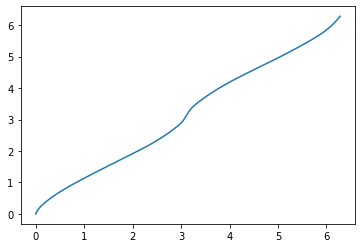

In [25]:
plt.plot(xi,model.predict(xi).detach().cpu().numpy())
plt.show()

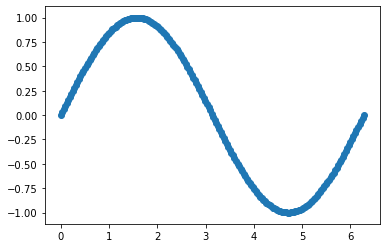

In [26]:
plt.scatter(xi,u(torch.tensor(xi)).numpy())
plt.show()

In [28]:
N = 1000
a = 0
b = 2*np.pi

si = np.linspace(a,b,N)
X = model.predict(si).detach().cpu().numpy()

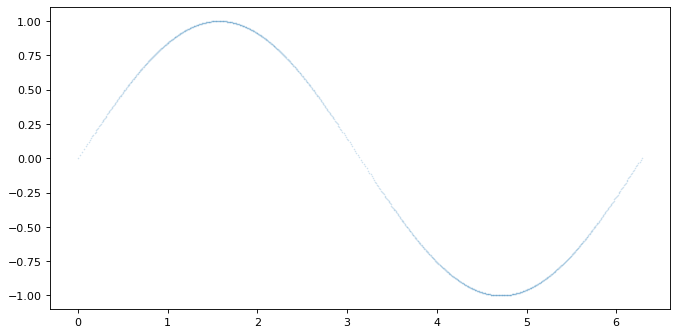

In [29]:
plt.figure(figsize=(10, 5), dpi=80)
plt.scatter(X,u(torch.tensor(X)).numpy(),s = 1e-2)
plt.show()